***Homework 1 AE502 - Anna Hylbert***

In [1]:
#import functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
import sympy as sy
import mpmath
import datetime
import julian

**Problem 1**

In [2]:
#define Karl Stumpff Equations for S and C

def S(z):
    if z>0:
        z = float(z)
        return (np.sqrt(z) - np.sin(np.sqrt(z))) / (np.sqrt(z)**3)
    elif z==0:
        return 1/6
    elif z<0:
        z_symbolic = sy.symbols("z_symbolic", real=True)
        f = (sy.sinh(sy.sqrt(-z_symbolic)) - sy.sqrt(-z_symbolic)) / (sy.sqrt(-z_symbolic)**3)
        f1 = sy.sinh(sy.sqrt(-z_symbolic))
        return float(f.subs(z_symbolic, z).evalf())

def C(z):
    if z>0:
        z = float(z)
        return (1-np.cos(np.sqrt(z)))/z
    elif z==0:
        return 1/2
    elif z<0:
        z_symbolic = sy.symbols("z_symbolic", real=True)
        f = (sy.cosh(sy.sqrt(-z_symbolic))-1) / (-z_symbolic)
        return float(f.subs(z_symbolic, z).evalf())

In [3]:
#define Kepler's Equations
def kepler(alpha, chi, r_0, v0_r, mu, delta_t):
    r_0_mag = np.linalg.norm(r_0)
    v0_r_mag = np.linalg.norm(v0_r)
    z = alpha * chi**2
    return (r_0_mag * v0_r_mag / np.sqrt(mu))*chi**2*C(z) + ((1-(alpha*r_0_mag))*chi**3*S(z)) + (r_0_mag * chi) - (np.sqrt(mu)*delta_t)

def kepler_prime(alpha, chi, r_0, v0_r, mu, delta_t):
    r_0_mag = np.linalg.norm(r_0)
    v0_r_mag = np.linalg.norm(v0_r)
    z = alpha * chi**2
    return (r_0_mag*v0_r_mag/np.sqrt(mu))*chi*(1 - (alpha*chi**2*S(z))) + ((1-(alpha*r_0_mag))*chi**2*C(z)) + r_0_mag

In [4]:
#solve keplers eqs with newtonian solver

def newt(alpha, r_0, v0_r, mu, delta_t, tol=10e-8):
    n_max = 1000
    n = 0
    chi_i = np.sqrt(mu) * np.abs(alpha) * delta_t
    i_ratio = kepler(alpha, chi_i, r_0, v0_r, mu, delta_t) / kepler_prime(alpha, chi_i, r_0, v0_r, mu, delta_t)
    while np.abs(i_ratio) >= tol and n<=n_max:
        n = n+1
        chi_i = chi_i - i_ratio
        i_ratio = kepler(alpha, chi_i, r_0, v0_r, mu, delta_t) / kepler_prime(alpha, chi_i, r_0, v0_r, mu, delta_t)
    return chi_i

In [5]:
#define f and g functions
def f1(chi, alpha, r_0_mag):
    return 1 - (chi**2*C(alpha*chi**2)/r_0_mag)

def g1(delta_t, chi, alpha, mu):
    return delta_t - (chi**3*S(alpha*chi**2)/np.sqrt(mu))

def f_dot1(mu, r_0_mag, alpha, chi, r_mag):
    return (np.sqrt(mu)/(r_mag*r_0_mag)) * (alpha*chi**3*S(alpha*chi**2) - chi)

def g_dot1(chi, r_mag, alpha):
    return (1 - (chi**2/r_mag * C(alpha*chi**2)))

#orbit propogation time!!
def orbit_propogator(r_0, v_0, delta_t, mu):
    """
    Inputs: 
    r_0 - initial position vector (km)
    v_0 - initial velocity vector (km/s)
    delta_t - elapsed time (s)
    mu - gravitational parameter (km^3/s^2)

    Outputs:
    r - final position vector (km)
    v - final velocity vector (km/s)  
    """
    r_0_mag = np.linalg.norm(r_0)
    v_0_mag = np.linalg.norm(v_0)
    v0_r = np.dot(v_0,r_0) / r_0_mag
    alpha = (2/r_0_mag) - (v_0_mag**2/mu)
    if alpha < 0:
        orbit_type = 'hyperbola'
    elif alpha == 0:
        orbit_type = 'parabola'
    elif alpha > 0 :
        orbit_type = 'ellipse'
    chi = newt(alpha, r_0, v0_r, mu, delta_t)
    r = ((f1(chi, alpha, r_0_mag)*r_0) + (g1(delta_t, chi, alpha, mu)*v_0)).astype(float)
    r_mag = np.linalg.norm(r)
    v = (f_dot1(mu, r_0_mag, alpha, chi, r_mag)*r_0 + g_dot1(chi, r_mag, alpha)*v_0).astype(float)
    return r,v
    

**Problem 2**

In [6]:
#solving lamberts problem with curtis 5.2

def y(z, r_1_mag, r_2_mag, A):
    #print('y', r_1_mag + r_2_mag + A*(z*S(z) - 1) / np.sqrt(C(z)))
    return r_1_mag + r_2_mag + A*(z*S(z) - 1) / np.sqrt(C(z))

def F(z, A, mu, delta_t, r_1_mag, r_2_mag):
    #print('F', (y(z, r_1_mag, r_2_mag, A)/C(z))**(3/2) * S(z) + (A*np.sqrt(y(z, r_1_mag, r_2_mag, A))) - (np.sqrt(mu)*delta_t))
    return (y(z, r_1_mag, r_2_mag, A)/C(z))**(3/2) * S(z) + (A*np.sqrt(y(z, r_1_mag, r_2_mag, A))) - (np.sqrt(mu)*delta_t)

def F_prime(z, A, r_1_mag, r_2_mag):
    if z != 0:
        return (y(z, r_1_mag, r_2_mag, A)/C(z))**(3/2) * (1/(2*z)*(C(z) - ((3*S(z))/(2*C(z)))) +  ((3*S(z)**2)/(4*C(z)))) + ((A/8)*(3*S(z)*np.sqrt(y(z, r_1_mag, r_2_mag, A))/C(z)
                + (A*np.sqrt(C(z)/y(z, r_1_mag, r_2_mag, A))))) 
    elif z==0:
        return np.sqrt(2) * y(0, r_1_mag, r_2_mag, A)**(3/2) / 40 + ((A/8)*(np.sqrt(y(0, r_1_mag, r_2_mag, A)) + (A*np.sqrt(1/(2*y(0, r_1_mag, r_2_mag, A))))))

def f(z, r_1_mag, r_2_mag, A):
    return 1 - (y(z, r_1_mag, r_2_mag, A)/r_1_mag)

def g(z, A, mu, r_1_mag, r_2_mag):
    return A * np.sqrt(y(z, r_1_mag, r_2_mag, A)/mu)

def f_dot(mu, r_1_mag, r_2_mag, z, A):
    return (np.sqrt(mu)/(r_1_mag*r_2_mag)) * np.sqrt(y(z, r_1_mag, r_2_mag, A)/C(z)) * (z*S(z) - 1)

def g_dot(z, r_1_mag, r_2_mag, A):
    return 1 - (y(z, r_1_mag, r_2_mag, A)/r_2_mag)
    
def newt_lambert(r_1_mag, r_2_mag, A, mu, delta_t, tol=10e-8):
    n_max = 100
    n = 0
    #z_i = 0 #may need to change later
    z_array = np.array([0,0]).reshape((1,2))
    for z in np.linspace(-100, 100, 100):
        initial_guess = F(z, A, mu, delta_t, r_1_mag, r_2_mag)
        z_array = np.append(z_array, np.array([z, initial_guess]).reshape((1,2)), axis=0)
    z_array[:,1] = np.sign(z_array[:,1])
    z_array = z_array[1:,:]
    z_array[:,1] = ((np.roll(z_array[:,1], 1) - z_array[:,1]) != 0).astype(int)
    z_i = z_array[np.where(z_array[:,1] != z_array[0][1])][0][0]
    F_ratio = F(z_i, A, mu, delta_t, r_1_mag, r_2_mag) / F_prime(z_i, A, r_1_mag, r_2_mag)
    while np.abs(F_ratio) > tol and n<=n_max:
        n = n+1
        z_i = z_i - F_ratio
        F_ratio = F(z_i, A, mu, delta_t, r_1_mag, r_2_mag) / F_prime(z_i, A, r_1_mag, r_2_mag)
    return z_i

def lambert(r_1, r_2, delta_t, mu, prograde=False, retrogade=False):
    r_1_mag = np.linalg.norm(r_1)
    r_2_mag = np.linalg.norm(r_2)
    if prograde == True:
        if np.cross(r_1,r_2)[2] >= 0:
            delta_theta = np.arccos(np.dot(r_1, r_2) / (r_1_mag*r_2_mag))
        elif np.cross(r_1,r_2)[2] < 0:
            delta_theta = (2*np.pi) - np.arccos(np.dot(r_1, r_2) / (r_1_mag*r_2_mag))
    elif retrogade == True:
        if np.cross(r_1,r_2)[2] < 0:
            delta_theta = np.arccos(np.dot(r_1, r_2) / (r_1_mag*r_2_mag))
        elif np.cross(r_1,r_2)[2] >= 0:
            delta_theta = (2*np.pi) - np.arccos(np.dot(r_1, r_2) / (r_1_mag*r_2_mag))
    A = np.sin(delta_theta)*np.sqrt(r_1_mag* r_2_mag / (1-np.cos(delta_theta)))
    z = newt_lambert(r_1_mag, r_2_mag, A, mu, delta_t)
    if z<0:
        orbit_type = 'hyperbola'
    elif z==0:
        orbit_type = 'parabola'
    elif z>0:
        orbit_type = 'ellipse'
    v_1 = (1/g(z, A, mu, r_1_mag, r_2_mag)) * (r_2 - (f(z, r_1_mag, r_2_mag, A)*r_1))
    v_2 = (1/g(z, A, mu, r_1_mag, r_2_mag)) * (g_dot(z, r_1_mag, r_2_mag, A)*r_2 - r_1)
    return v_1, v_2


In [7]:
r1 = np.array([5644, 2830, 4170]) #km
r2 = np.array([-2240, 7320, 4980]) #km
mu = 3.986004418 * 10**5 #km^3/s^2
tof= 1200 #s

lambert(r1, r2, tof, mu, prograde=False, retrogade=True)

(array([ 1.75347464, -5.38237393, -3.62508869]),
 array([4.50085225, 1.0688452 , 2.39185073]))

Going to need to take r0 of Earth and propogate everyday for x days, do the same with two destination locations, and then plug r_1 and r_2 for everyday into lamberts problem to get total delta_v ... this will give all data needed for porkchop plots

**Problem 3**

In [8]:
#givens 

AUD = u.AU / u.day

r0_1I_AU = np.array([3.515868886595499e-2, -3.162046390773074, 4.493983111703389]) * u.AU  #AU
v0_1I_AU = np.array([-2.317577766980901e-3, 9.843360903693031e-3, -1.541856855538041e-2]) * AUD #AU/Day

r0_earth_AU = np.array([1.796136509111975e-1, 9.667949206859814e-1, -3.668681017942158e-5]) * u.AU #AU
v0_earth_AU = np.array([-1.720038360888334e-2, -3.211186197806460e-3, 7.927736735960840e-7])* AUD #AU/Day


In [9]:
#converting to km and km/s units to work with propogator (using astropy)

kms = u.km / u.s

r0_1I = r0_1I_AU.to(u.km)
v0_1I = v0_1I_AU.to(kms)

r0_earth = r0_earth_AU.to(u.km)
v0_earth = v0_earth_AU.to(kms)

mu_sun = 1.327 * 10**11 #km^3/s^2


In [10]:
#define launch and arrival windows
launch_window_start = pd.Timestamp(year = 2017, month = 1, day = 1, hour = 0, minute = 0, second = 0).to_julian_date()
launch_window_end = pd.Timestamp(year = 2017, month = 12, day = 31, hour = 0, minute = 0, second = 0).to_julian_date()
launch_window_range_julian = np.arange(launch_window_start, launch_window_end, step=1)
launch_window_delta_t = np.arange(1, len(launch_window_range_julian) + 1) * 86400

arrival_window_start = pd.Timestamp(year = 2017, month = 8, day = 1, hour = 0, minute = 0, second = 0).to_julian_date()
arrival_window_end = pd.Timestamp(year = 2019, month = 1, day = 31, hour = 0, minute = 0, second = 0).to_julian_date()
arrival_window = np.arange(arrival_window_start, arrival_window_end, step=1)

In [11]:
#get location and velocity of earth during launch window
earth_position_vector = r0_earth.value.reshape((1,3))
earth_velocity_vector = v0_earth.value.reshape((1,3))
for day in np.arange(1, len(launch_window_range_julian)):
    r_t, v_t = orbit_propogator(r0_earth.value, v0_earth.value, launch_window_delta_t[day], mu_sun)
    r_t = r_t.reshape((1,3))
    v_t = v_t.reshape((1,3))
    earth_position_vector = np.append(earth_position_vector, r_t, axis=0)
    earth_velocity_vector = np.append(earth_velocity_vector, v_t, axis=0)

#get location and velocity of 1I during launch window
position_vector_1I = r0_1I.value.reshape((1,3))
velocity_vector_1I = v0_1I.value.reshape((1,3))
for day in np.arange(1, len(launch_window_range_julian)):
    r_t, v_t = orbit_propogator(r0_1I.value, v0_1I.value, launch_window_delta_t[day], mu_sun)
    r_t = r_t.reshape((1,3))
    v_t = v_t.reshape((1,3))
    position_vector_1I = np.append(position_vector_1I, r_t, axis=0)
    velocity_vector_1I = np.append(velocity_vector_1I, v_t, axis=0)


In [12]:
#given delta v conditions
max_delta_v_rendezvous = 50 #km/s
max_delta_v_flyby = 20 #km/s

#initialize vector of transfer start date, transfer end date, and delta_v of transfers that meet delta v conditions
transfer_time_delta_v_rendezvous = np.array([0,0,0]).reshape(1,3)
transfer_time_delta_v_flyby = np.array([0,0,0]).reshape(1,3)

for i in np.arange(len(launch_window_range_julian)):
    delta_t_possibilities = np.array([])
    for t in np.arange(len(arrival_window)):
        if arrival_window[t] >= launch_window_range_julian[i]:
            delta_t = (arrival_window[t] - launch_window_range_julian[i]) * 86400
            delta_t_possibilities = np.append(delta_t_possibilities, delta_t)
    for k in np.arange(len(delta_t_possibilities)):
        #position_vector_1I_final, velocity_vector_1I_final = orbit_propogator(position_vector_1I[i], velocity_vector_1I[i], delta_t_possibilities[k], mu_sun)
        try:
            v_1_transfer_prograde, v_2_transfer_prograde = lambert(earth_position_vector[i], position_vector_1I[i], delta_t_possibilities[k], mu_sun, prograde=True, retrogade=False)
            v_1_transfer_retrogade, v_2_transfer_retrogade = lambert(earth_position_vector[i], position_vector_1I[i], delta_t_possibilities[k], mu_sun, prograde=False, retrogade=True)
            if np.linalg.norm([v_1_transfer_prograde]) + np.linalg.norm([v_2_transfer_prograde]) <= np.linalg.norm([v_1_transfer_retrogade]) + np.linalg.norm([v_2_transfer_retrogade]):
                v_1_transfer = v_1_transfer_prograde
                v_2_transfer = v_2_transfer_prograde
            elif np.linalg.norm([v_1_transfer_prograde]) + np.linalg.norm([v_2_transfer_prograde]) >= np.linalg.norm([v_1_transfer_retrogade]) + np.linalg.norm([v_2_transfer_retrogade]):
                v_1_transfer = v_1_transfer_retrogade
                v_2_transfer = v_2_transfer_retrogade
        except:
            print('overflow issue')
        delta_v_earth = abs(np.linalg.norm(v_1_transfer - earth_velocity_vector[i]))
        delta_v_1I = abs(np.linalg.norm(v_2_transfer - velocity_vector_1I[i]))
        delta_v = delta_v_earth + delta_v_1I
        if delta_v <= max_delta_v_rendezvous:
            transfer_time_delta_v_rendezvous = np.append(transfer_time_delta_v_rendezvous, np.array([launch_window_range_julian[i], 
                                                                                            launch_window_range_julian[i]+ (delta_t_possibilities[k]/86400), 
                                                                                            delta_v]).reshape(1,3), axis=0)
        if delta_v <= max_delta_v_flyby:
            transfer_time_delta_v_flyby = np.append(transfer_time_delta_v_flyby, np.array([launch_window_range_julian[i], 
                                                                                            launch_window_range_julian[i]+ (delta_t_possibilities[k]/86400), 
                                                                                            delta_v]).reshape(1,3), axis=0)



/var/folders/yp/4p3dzzvn3gddn3mzn6_q2xfr0000gn/T/ipykernel_14161/1847723725.py:9: RuntimeWarning: invalid value encountered in double_scalars
  return (y(z, r_1_mag, r_2_mag, A)/C(z))**(3/2) * S(z) + (A*np.sqrt(y(z, r_1_mag, r_2_mag, A))) - (np.sqrt(mu)*delta_t)
/var/folders/yp/4p3dzzvn3gddn3mzn6_q2xfr0000gn/T/ipykernel_14161/1847723725.py:9: RuntimeWarning: invalid value encountered in sqrt
  return (y(z, r_1_mag, r_2_mag, A)/C(z))**(3/2) * S(z) + (A*np.sqrt(y(z, r_1_mag, r_2_mag, A))) - (np.sqrt(mu)*delta_t)
/var/folders/yp/4p3dzzvn3gddn3mzn6_q2xfr0000gn/T/ipykernel_14161/1847723725.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return r_1_mag + r_2_mag + A*(z*S(z) - 1) / np.sqrt(C(z))
/var/folders/yp/4p3dzzvn3gddn3mzn6_q2xfr0000gn/T/ipykernel_14161/1847723725.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  F_ratio = F(z_i, A, mu, delta_t, r_1_mag, r_2_mag) / F_prime(z_i, A, r_1_mag, r_2_mag)
/var/folders/yp/4p3dzzvn3gddn3mzn6_q2xfr0000gn/T/

overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow i

/var/folders/yp/4p3dzzvn3gddn3mzn6_q2xfr0000gn/T/ipykernel_14161/1847723725.py:5: RuntimeWarning: overflow encountered in double_scalars
  return r_1_mag + r_2_mag + A*(z*S(z) - 1) / np.sqrt(C(z))


overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow issue
overflow i

Text(0.5, 1.0, 'Porkchop Plot for Rendezvous with I1')

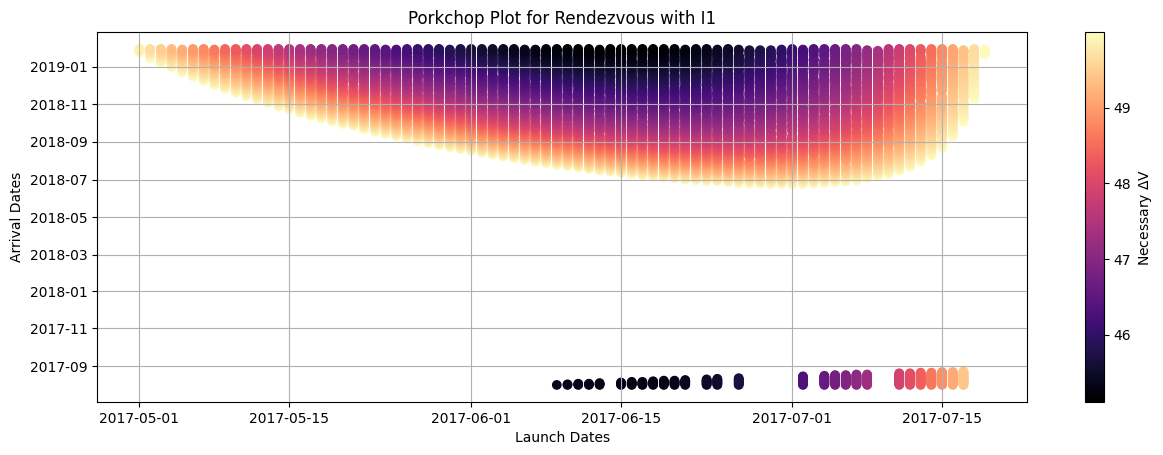

In [ ]:
departure_dates_julian = transfer_time_delta_v_rendezvous[:,0][1:]
arrival_dates_julian = transfer_time_delta_v_rendezvous[:,1][1:]

departure_dates = pd.to_datetime(departure_dates_julian, unit = "D", origin = "julian")
arrival_dates = pd.to_datetime(arrival_dates_julian, unit = "D", origin = "julian")

delta_v = transfer_time_delta_v_rendezvous[:,2][1:]

#plotting time !!
plt.figure().set_figwidth(15)
plt.grid()
plt.scatter(departure_dates, arrival_dates, c=delta_v, cmap="magma")
plt.colorbar(label= f'Necessary $\Delta$V')
plt.xlabel('Launch Dates')
plt.ylabel('Arrival Dates')
plt.title('Porkchop Plot for Rendezvous with I1')


Text(0.5, 1.0, 'Porkchop Plot for Flyby with I1')

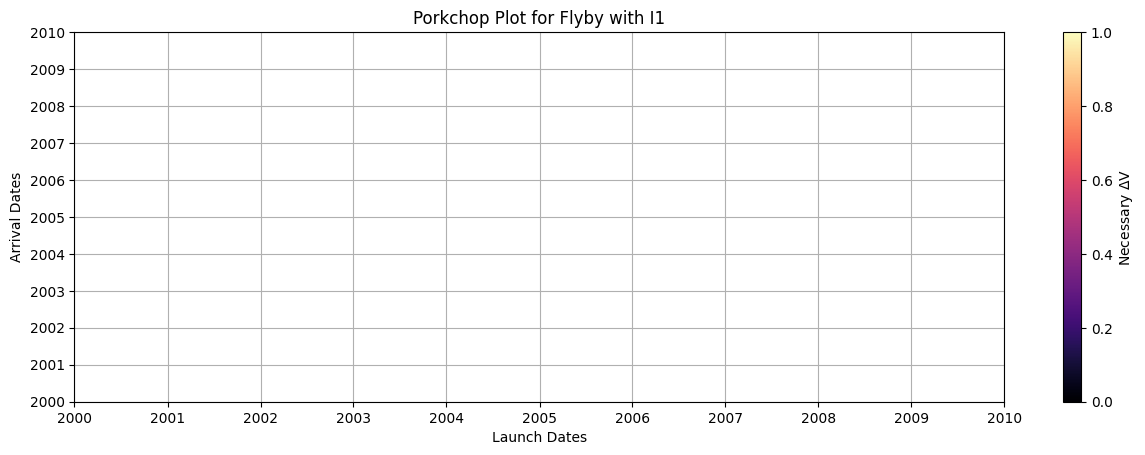

In [ ]:
departure_dates_julian = transfer_time_delta_v_flyby[:,0][1:]
arrival_dates_julian = transfer_time_delta_v_flyby[:,1][1:]

departure_dates = pd.to_datetime(departure_dates_julian, unit = "D", origin = "julian")
arrival_dates = pd.to_datetime(arrival_dates_julian, unit = "D", origin = "julian")

delta_v = transfer_time_delta_v_flyby[:,2][1:]

#plotting time !!
plt.figure().set_figwidth(15)
plt.grid()
plt.scatter(departure_dates, arrival_dates, c=delta_v, cmap="magma")
plt.colorbar(label= f'Necessary $\Delta$V')
plt.xlabel('Launch Dates')
plt.ylabel('Arrival Dates')
plt.title('Porkchop Plot for Flyby with I1')

**Problem 4**

In [ ]:
#givens
r0_2I_AU = np.array([7.249472033259724, 14.61063037906177, 14.24274452216359]) * u.AU #AU
v0_2I_AU = np.array([-8.241709369476881e-3, -1.156219024581502e-2, -1.317135977481448e-2]) * AUD#AU/Day

r0_earth_AU = np.array([1.796136509111975e-1, 9.667949206859814e-1, -3.668681017942158e-5]) * u.AU #AU
v0_earth_AU = np.array([-1.720038360888334e-2, -3.211186197806460e-3, 7.927736735960840e-7])* AUD #AU/Day

In [ ]:
#converting to km and km/s units to work with propogator (using astropy)

kms = u.km / u.s

r0_2I = r0_2I_AU.to(u.km)
v0_2I = v0_2I_AU.to(kms)

r0_earth = r0_earth_AU.to(u.km)
v0_earth = v0_earth_AU.to(kms)

mu_sun = 1.327 * 10**11 #km^3/s^2

In [ ]:
#define launch and arrival windows
launch_window_start = pd.Timestamp(year = 2017, month = 1, day = 1, hour = 0, minute = 0, second = 0).to_julian_date()
launch_window_end = pd.Timestamp(year = 2017, month = 7, day = 31, hour = 0, minute = 0, second = 0).to_julian_date()
launch_window_range_julian = np.arange(launch_window_start, launch_window_end, step=1)
launch_window_delta_t = np.arange(1, len(launch_window_range_julian) + 1) * 86400

arrival_window_start = pd.Timestamp(year = 2019, month = 6, day = 1, hour = 0, minute = 0, second = 0).to_julian_date()
arrival_window_end = pd.Timestamp(year = 2022, month = 1, day = 31, hour = 0, minute = 0, second = 0).to_julian_date()
arrival_window = np.arange(arrival_window_start, arrival_window_end, step=1)

In [ ]:
#get location and velocity of earth during launch window
earth_position_vector = r0_earth.value.reshape((1,3))
earth_velocity_vector = v0_earth.value.reshape((1,3))
for day in np.arange(1, len(launch_window_range_julian)):
    r_t, v_t = orbit_propogator(r0_earth.value, v0_earth.value, launch_window_delta_t[day], mu_sun)
    r_t = r_t.reshape((1,3))
    v_t = v_t.reshape((1,3))
    earth_position_vector = np.append(earth_position_vector, r_t, axis=0)
    earth_velocity_vector = np.append(earth_velocity_vector, v_t, axis=0)

#get location and velocity of 2I during launch window
position_vector_2I = r0_2I.value.reshape((1,3))
velocity_vector_2I = v0_2I.value.reshape((1,3))
for day in np.arange(1, len(launch_window_range_julian)):
    r_t, v_t = orbit_propogator(r0_2I.value, v0_2I.value, launch_window_delta_t[day], mu_sun)
    r_t = r_t.reshape((1,3))
    v_t = v_t.reshape((1,3))
    position_vector_2I = np.append(position_vector_2I, r_t, axis=0)
    velocity_vector_2I = np.append(velocity_vector_2I, v_t, axis=0)

In [ ]:
#given delta v conditions
max_delta_v_rendezvous = 60 #km/s
max_delta_v_flyby = 20 #km/s

#initialize vector of transfer start date, transfer end date, and delta_v of transfers that meet delta v conditions
transfer_time_delta_v_rendezvous = np.array([0,0,0]).reshape(1,3)
transfer_time_delta_v_flyby = np.array([0,0,0]).reshape(1,3)

for i in np.arange(len(launch_window_range_julian)):
    delta_t_possibilities = np.array([])
    for t in np.arange(len(arrival_window)):
        if arrival_window[t] >= launch_window_range_julian[i]:
            delta_t = (arrival_window[t] - launch_window_range_julian[i]) * 86400
            delta_t_possibilities = np.append(delta_t_possibilities, delta_t)
    for k in np.arange(len(delta_t_possibilities)):
        #position_vector_1I_final, velocity_vector_1I_final = orbit_propogator(position_vector_1I[i], velocity_vector_1I[i], delta_t_possibilities[k], mu_sun)
        try:
            v_1_transfer, v_2_transfer = lambert(earth_position_vector[i], position_vector_2I[i], delta_t_possibilities[k], mu_sun, prograde=True, retrogade=False)
        except:
            print('overflow issue')
        delta_v_earth = abs(np.linalg.norm(v_1_transfer) - np.linalg.norm(earth_velocity_vector[i]))
        delta_v_2I = abs(np.linalg.norm(v_2_transfer) - np.linalg.norm(velocity_vector_2I[i]))
        delta_v = delta_v_earth + delta_v_2I
        if delta_v <= max_delta_v_rendezvous:
            transfer_time_delta_v_rendezvous = np.append(transfer_time_delta_v_rendezvous, np.array([launch_window_range_julian[i], 
                                                                                            launch_window_range_julian[i]+ (delta_t_possibilities[k]/86400), 
                                                                                            delta_v]).reshape(1,3), axis=0)
        if delta_v <= max_delta_v_flyby:
            transfer_time_delta_v_flyby = np.append(transfer_time_delta_v_flyby, np.array([launch_window_range_julian[i], 
                                                                                            launch_window_range_julian[i]+ (delta_t_possibilities[k]/86400), 
                                                                                            delta_v]).reshape(1,3), axis=0)

overflow issue
overflow issue


In [ ]:
departure_dates_julian = transfer_time_delta_v_rendezvous[:,0][1:]
arrival_dates_julian = transfer_time_delta_v_rendezvous[:,1][1:]

departure_dates = pd.to_datetime(departure_dates_julian, unit = "D", origin = "julian")
arrival_dates = pd.to_datetime(arrival_dates_julian, unit = "D", origin = "julian")

delta_v = transfer_time_delta_v_rendezvous[:,2][1:]

#plotting time !!
plt.figure().set_figwidth(15)
plt.grid()
plt.scatter(departure_dates, arrival_dates, c=delta_v, cmap="magma")
plt.colorbar(label= f'Necessary $\Delta$V')
plt.xlabel('Launch Dates')
plt.ylabel('Arrival Dates')
plt.title('Porkchop Plot for Rendezvous with I2')

In [ ]:
departure_dates_julian = transfer_time_delta_v_flyby[:,0][1:]
arrival_dates_julian = transfer_time_delta_v_flyby[:,1][1:]

departure_dates = pd.to_datetime(departure_dates_julian, unit = "D", origin = "julian")
arrival_dates = pd.to_datetime(arrival_dates_julian, unit = "D", origin = "julian")

delta_v = transfer_time_delta_v_flyby[:,2][1:]

#plotting time !!
plt.figure().set_figwidth(15)
plt.grid()
plt.scatter(departure_dates, arrival_dates, c=delta_v, cmap="magma")
plt.colorbar(label= f'Necessary $\Delta$V')
plt.xlabel('Launch Dates')
plt.ylabel('Arrival Dates')
plt.title('Porkchop Plot for Flyby with I2')

**Question 4**

In [ ]:
def orbit_rv_to_elements(r_initial, v_initial):
    
    i_vec = [1, 0, 0]
    j = [0, 1, 0]
    k = [0, 0, 1]

    a = 1/((2/np.linalg.norm(r_initial))-(np.linalg.norm(v_initial)**2/mu))

    e_array = ((np.linalg.norm(v_initial)**2/mu)-(1/np.linalg.norm(r_initial)))*r_initial - (1/mu)*np.dot(r_initial, v_initial)*v_initial
    e = np.linalg.norm(e_array)

    h_array = np.cross(r_initial, v_initial)
    i = np.arccos(np.dot((h_array/np.linalg.norm(h_array)), k))

    n_array = np.cross(k, h_array)
    omega = np.arccos(np.dot(n_array, i_vec)/np.linalg.norm(n_array))
    if np.dot(n_array, j) < 0:
        omega = 2*np.pi - omega

    w = np.arccos(np.dot(n_array, e_array)/(np.linalg.norm(n_array)*np.linalg.norm(e_array)))
    if np.dot(e_array, k) < 0:
        w = 2*np.pi - w
        
    return a, e, i, omega, w

In [ ]:
a_earth, e_earth, i_earth, omega_earth, w_earth = orbit_rv_to_elements(r0_earth.value, v0_earth.value)
a_I1, e_I1, i_I1, omega_I1, w_I1 = orbit_rv_to_elements(r0_1I.value, v0_1I.value)
a_I2, e_I2, i_I2, omega_I2, w_I2 = orbit_rv_to_elements(r0_2I.value, v0_2I.value)

print('The Orbital Elements of Earth')
print('a_earth =', a_earth)
print('e_earth = ', e_earth)
print('i_earth = ', i_earth)
print('Omega_earth = ', omega_earth)
print('omega_earth = ', w_earth)

print('The Orbital Elements of I1')
print('a_I1 =', a_I1)
print('e_I1 = ', e_I1)
print('i_I1 = ', i_I1)
print('Omega_I1 = ', omega_I1)
print('omega_I1 = ', w_I1)

print('The Orbital Elements of I2')
print('a_I2 =', a_I2)
print('e_I2 = ', e_I2)
print('i_I2 = ', i_I2)
print('Omega_I2 = ', omega_I2)
print('omega_I2 = ', w_I2)

This shows that the orbits of I1 and I2 are both not closed and are therefore interstellar. 

**Question 5**

For flying to I1, only the rendezvous mission scenario was possible. Additionally, there were two fairly wide ranges you could launch in, one of which had the possibility of a relatively low delta v. Because of this, I would select that mission scenario. 